In [2]:
import numpy as np
from sklearn.utils.extmath import svd_flip, randomized_svd
from scipy.sparse.linalg import svds
import torch
import matplotlib.pyplot as plt
import sys
import scipy.io as sio

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
if device == 'cuda':
    # when using GPU use this block of code
    gpu_path = '/home/akumar/data/KLCPD_data/code'
    sys.path.append(gpu_path)
    from main import KL_CPD
    codar_file_path = '/home/akumar/data/KLCPD_data/collision_0-256.mat'
else:
    # when using CPU use this block of code
    cpu_path = '/Users/aniketkumar/Desktop/Aniket/ML/cpd-pytorch/MDTrAnal_exp/klcpd-code'
    sys.path.append(cpu_path)
    from main import KL_CPD
    codar_file_path = '../test/data/collision_0-256.mat'

codar_file_path

'/home/akumar/data/KLCPD_data/collision_0-256.mat'

In [5]:
def svd_wrapper(Y, k, method='svds'):
    if method == 'svds':
        Ut, St, Vt = svds(Y, k)
        idx = np.argsort(St)[::-1]
        St = St[idx] # have issue with sorting zero singular values
        Ut, Vt = svd_flip(Ut[:, idx], Vt[idx])
    elif method == 'random':
        Ut, St, Vt = randomized_svd(Y, k, random_state=0)
    else:
        Ut, St, Vt = np.linalg.svd(Y, full_matrices=False)
        # now truncate it to k
        Ut = Ut[:, :k]
        St = np.diag(St[:k])
        Vt = Vt[:k, :]
        
    return Ut, St, Vt

In [6]:
def get_codar_coordinates():
    codar_data = sio.loadmat(codar_file_path)
    (x1, y1, z1) = codar_data['trace'].shape
    return codar_data['trace'].reshape(x1, y1*z1, order='C')

In [7]:
def get_reduced_data(components, svd_method):
    p_data = get_codar_coordinates()
    X, s, v = svd_wrapper(p_data, components, method=svd_method)
    return X, s, v

In [8]:
def train_and_pred_dataset(dataset):
    dim_codar = dataset.shape[1]
    model_codar = KL_CPD(dim_codar).to(device)
    model_codar.fit(dataset)
    return model_codar.predict(dataset)

In [29]:
def plot_data(dataset, predictions, reduction_method, skip_components=0):
    components = dataset.shape[1]
    # get the min and max values for y-axis
    min_y=float('inf')
    max_y=float('-inf')
    for i in range(components):
        if skip_components == i+1:
            continue
        min_y = min(min_y, min(dataset[:,i]))
        max_y = max(max_y, max(dataset[:,i]))

    for i in range(components):
        if skip_components == i+1:
            continue
        plt.subplot(components+1,1,i+1)
        plt.plot(dataset[:,i])
        plt.title(f'Component {i+1}')
        plt.ylim([min_y-0.2, max_y+0.2])
        plt.subplot(components+1, 1, components+1)

    plt.plot(predictions)
    plt.title('MMD')
    plt.suptitle(f'{reduction_method} with {components-skip_components} component(s) visualization')
    plt.tight_layout()
    plt.show()

In [9]:
svd_method = 'random'
components = 2
codar_reduced = get_reduced_data(components, svd_method)

In [15]:
cov_mat = np.cov(codar_reduced.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
eigen_vals, eigen_vecs

(array([3.28452543e-14, 3.93700787e-03]),
 array([[-1.00000000e+00, -6.07625074e-06],
        [ 6.07625074e-06, -1.00000000e+00]]))

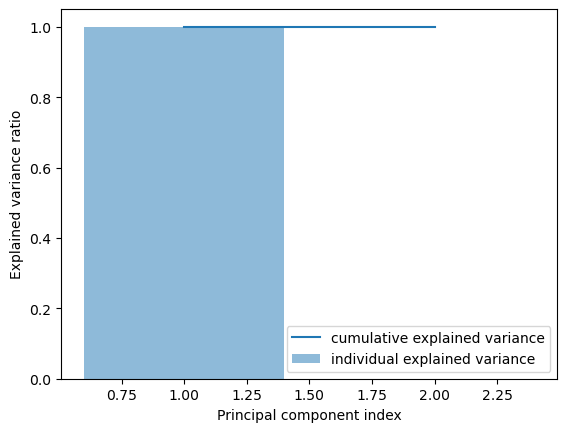

In [16]:
# calculate cumulative sum of explained variances
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.bar(range(1,components+1), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,components+1), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [17]:
# var_exp, cum_var_exp
components = 1

([0.9999999999916573, 8.342694590643208e-12], array([1., 1.]))

In [23]:
codar_reduced_component = codar_reduced[:,1].reshape(-1,1)

In [24]:
preds_codar = train_and_pred_dataset(codar_reduced_component)

100%|████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


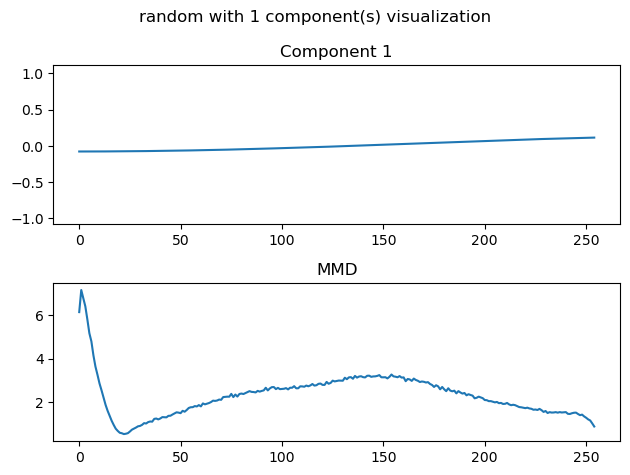

In [25]:
plot_data(codar_reduced_component, preds_codar, svd_method)

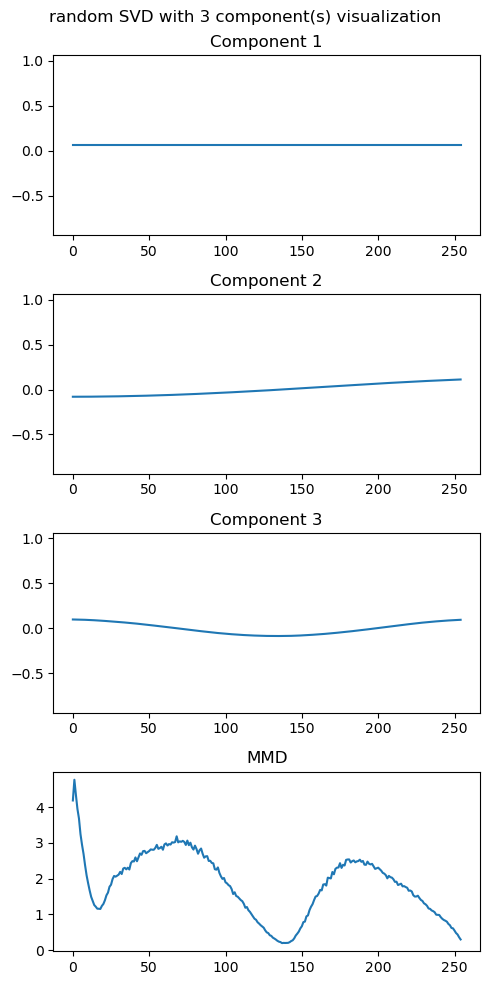

In [53]:
plt.figure(figsize=(5,10))
for i in range(components):
    plt.subplot(components+1,1,i+1)
    plt.plot(codar_reduced[:,i])
    plt.title(f'Component {i+1}')
    ymin = min(codar_reduced[:,0])-1
    ymax = max(codar_reduced[:,0])+1
    plt.ylim([ymin, ymax])
    plt.subplot(components+1, 1, components+1)

plt.plot(preds_codar)
plt.title('MMD')
plt.suptitle(f'{svd_method} SVD with {components} component(s) visualization')
plt.tight_layout()
plt.show()

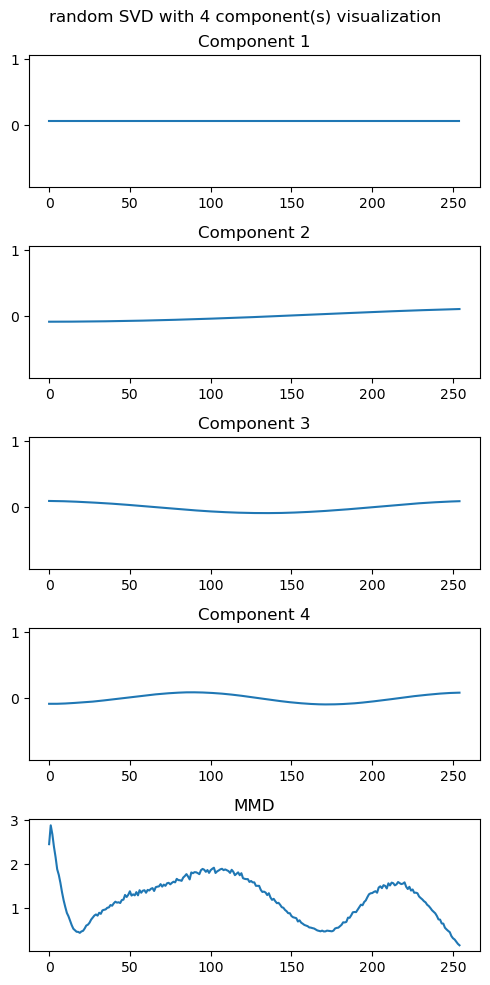

In [45]:
plt.figure(figsize=(5,10))
for i in range(components):
    plt.subplot(components+1,1,i+1)
    plt.plot(codar_reduced[:,i])
    plt.title(f'Component {i+1}')
    ymin = min(codar_reduced[:,0])-1
    ymax = max(codar_reduced[:,0])+1
    plt.ylim([ymin, ymax])
    plt.subplot(components+1, 1, components+1)

plt.plot(preds_codar)
plt.title('MMD')
plt.suptitle(f'{svd_method} SVD with {components} component(s) visualization')
plt.tight_layout()
plt.show()

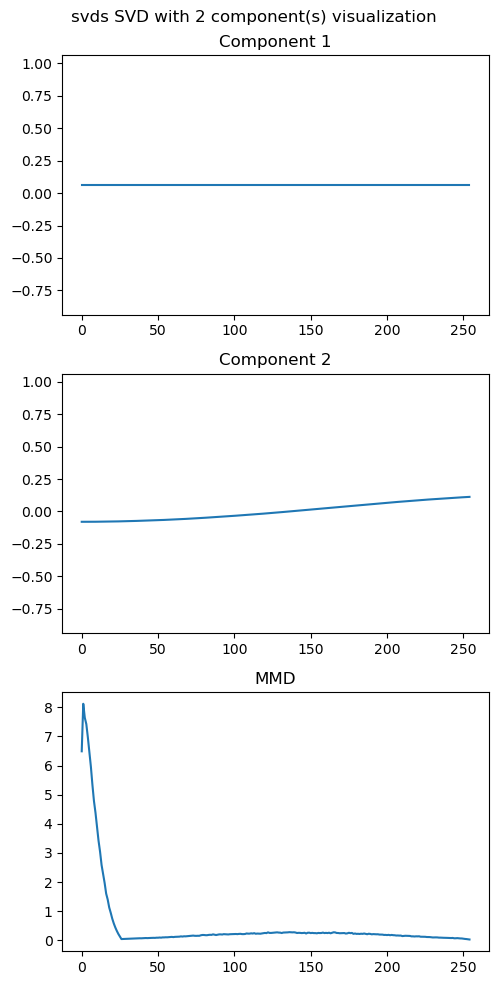

In [58]:
plt.figure(figsize=(5,10))
for i in range(components):
    plt.subplot(components+1,1,i+1)
    plt.plot(codar_reduced[:,i])
    plt.title(f'Component {i+1}')
    ymin = min(codar_reduced[:,0])-1
    ymax = max(codar_reduced[:,0])+1
    plt.ylim([ymin, ymax])
    plt.subplot(components+1, 1, components+1)

plt.plot(preds_codar)
plt.title('MMD')
plt.suptitle(f'{svd_method} SVD with {components} component(s) visualization')
plt.tight_layout()
plt.show()

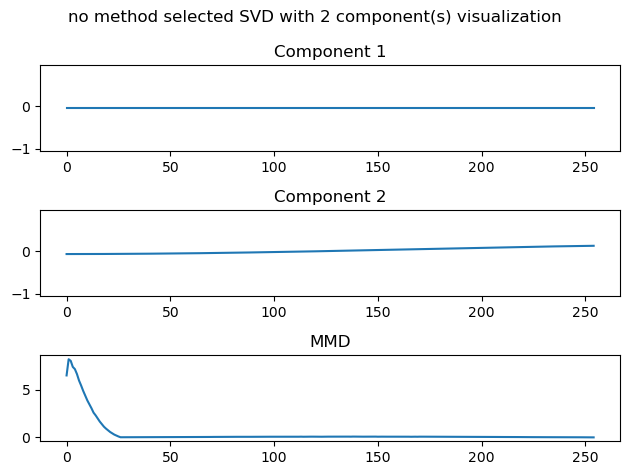

In [64]:
for i in range(components):
    plt.subplot(components+1,1,i+1)
    plt.plot(codar_reduced[:,i])
    plt.title(f'Component {i+1}')
    ymin = min(codar_reduced[:,0])-1
    ymax = max(codar_reduced[:,0])+1
    plt.ylim([ymin, ymax])
    plt.subplot(components+1, 1, components+1)

plt.plot(preds_codar)
plt.title('MMD')
plt.suptitle(f'{svd_method} SVD with {components} component(s) visualization')
plt.tight_layout()
plt.show()

In [14]:
codar = get_codar_coordinates()

Normalize the CODAR data

In [15]:
from sklearn.preprocessing import StandardScaler

# standardize the data
scaler = StandardScaler(with_std=False)
codar_scaled = scaler.fit_transform(codar)
codar_scaled.shape

(255, 27099)

In [30]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

model = TruncatedSVD(n_components=3)
model.fit(codar_scaled)
codar_proj = model.transform(codar_scaled)
explained_variances = np.var(codar_proj, axis=0) / np.var(codar, axis=0).sum()
len(explained_variances), codar_proj.shape, codar.shape

(3, (255, 3), (255, 27099))

In [31]:
model.explained_variance_, explained_variances, model.singular_values_

(array([656.43983164,  80.96652982,  30.97417597]),
 array([0.78577768, 0.0969193 , 0.03707699]),
 array([409.13586627, 143.68877863,  88.87302669]))

<BarContainer object of 3 artists>

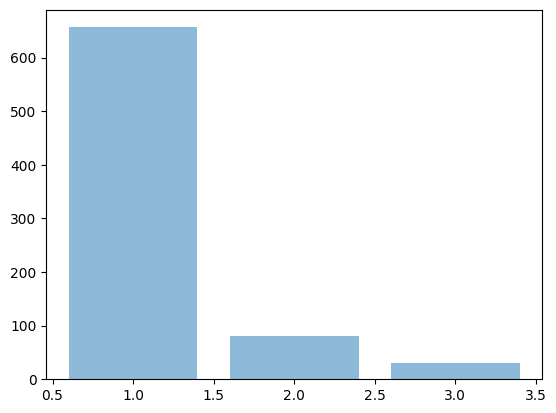

In [32]:
plt.bar(range(1,4), model.explained_variance_, alpha=0.5)

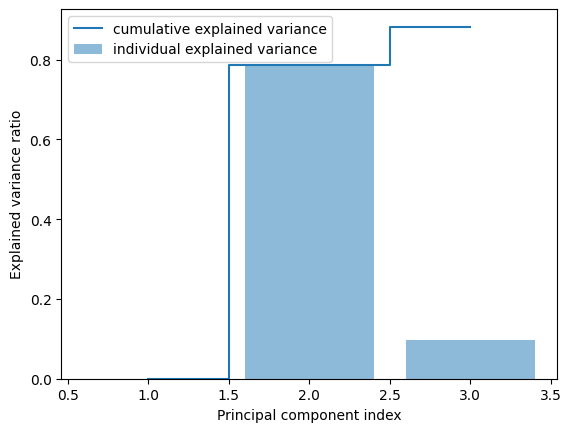

In [19]:
plt.bar(range(1,4), explained_variances, alpha=0.5,align='center', label='individual explained variance')
plt.step(range(1,4), np.cumsum(explained_variances), where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [36]:
preds_t_svd = train_and_pred_dataset(codar_proj)

100%|██████████| 100/100 [02:17<00:00,  1.38s/it]


In [45]:
model.explained_variance_ratio_, explained_variances, model.explained_variance_

(array([1.48013386e-05, 7.85765605e-01, 9.69188622e-02]),
 [0.78576560490488, 0.09691886217443614, 1.4801338573999924e-05],
 array([1.23650601e-02, 6.56429746e+02, 8.09661604e+01]))

In [39]:
skip_component = 1

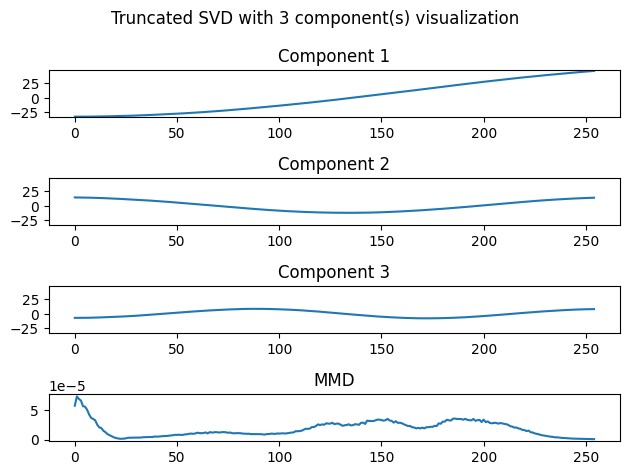

In [41]:
plot_data(codar_proj, preds_t_svd, 'Truncated SVD')

In [73]:
svd_method = 'random'
components = 3
codar_reduced, sigma, vt = get_reduced_data(components, svd_method)
explained_variances = np.var(codar_reduced, axis=0) / np.var(codar, axis=0).sum()
explained_variances

array([2.12477264e-16, 4.69423235e-06, 4.69423235e-06])

In [74]:
sigma, vt

(array([2.63933346e+05, 4.09132723e+02, 1.43688451e+02]),
 array([[-0.00232241,  0.00191566,  0.00753887, ...,  0.00065721,
          0.00152268,  0.00833807],
        [ 0.00628882,  0.00426916,  0.01536466, ...,  0.00577196,
          0.00310528,  0.00884209],
        [ 0.0014988 , -0.00235613,  0.01316923, ..., -0.03472891,
          0.0304743 ,  0.05397959]]))

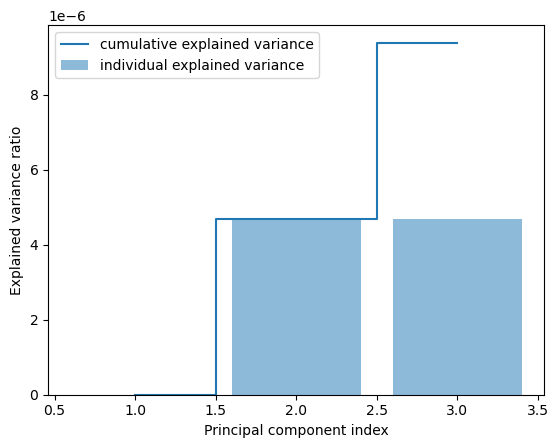

In [71]:
plt.bar(range(1,components+1), explained_variances, alpha=0.5,align='center', label='individual explained variance')
plt.step(range(1,components+1), np.cumsum(explained_variances), where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [64]:
preds = train_and_pred_dataset(codar_reduced)

100%|████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


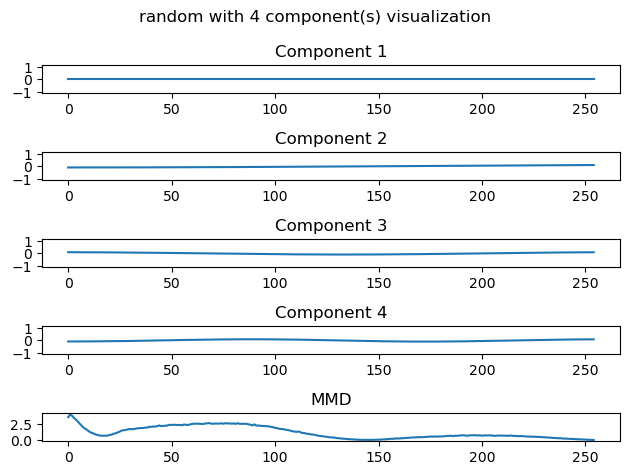

In [65]:
plot_data(codar_reduced, preds, svd_method)

In [56]:
svd_method = 'svds'
components = 3
codar_scaled_svds, s, v = svd_wrapper(codar_scaled, components, method=svd_method)

(-1.0, 1.0)

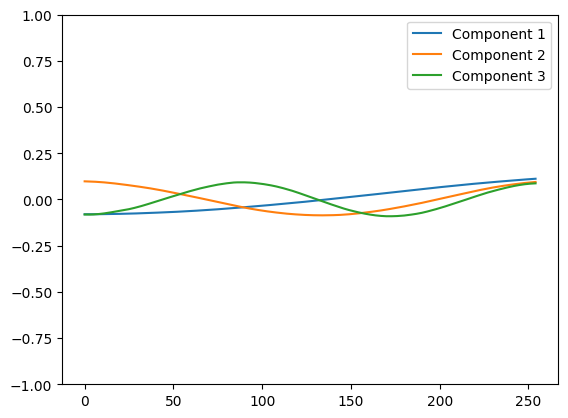

In [78]:
plt.plot(codar_scaled_svds[:,0])
plt.plot(codar_scaled_svds[:,1])
plt.plot(codar_scaled_svds[:,2])
plt.legend(['Component 1', 'Component 2', 'Component 3'])
plt.ylim([-1,1])

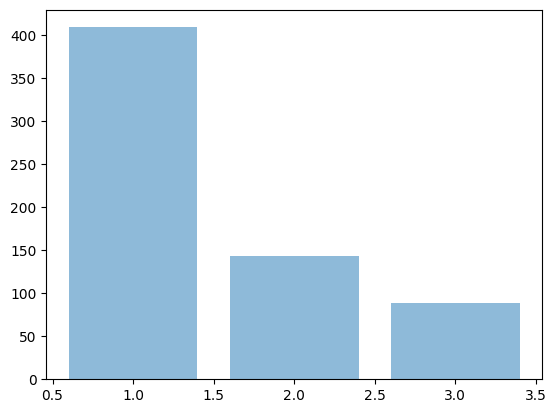

In [65]:
plt.bar([1,2,3], s, alpha=0.5,align='center', label='individual explained variance')
plt.show()

In [57]:
preds_codar_scaled_svds = train_and_pred_dataset(codar_scaled_svds)

100%|██████████| 100/100 [02:22<00:00,  1.42s/it]


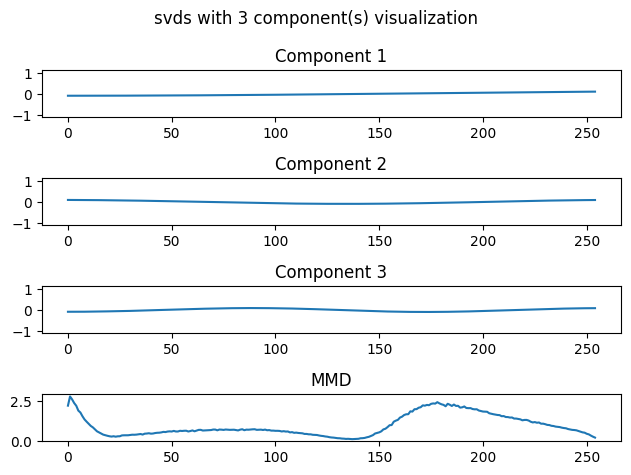

In [59]:
plot_data(codar_scaled_svds, preds_codar_scaled_svds, svd_method)

Using only 2nd and 3rd components to train the model

In [80]:
preds_codar_scaled_svds = train_and_pred_dataset(codar_scaled_svds[:,1:])

100%|██████████| 100/100 [02:18<00:00,  1.39s/it]


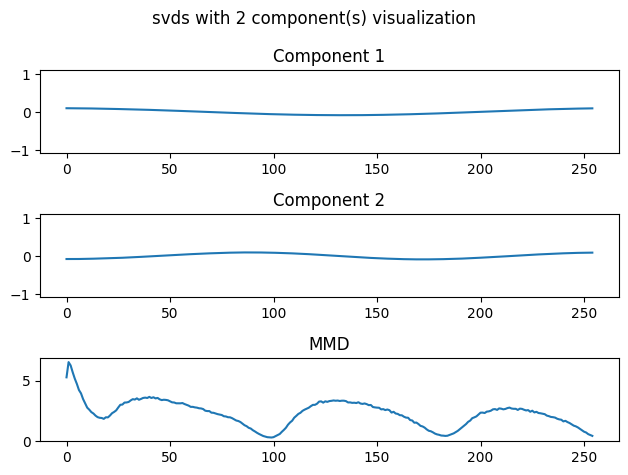

In [83]:
plot_data(codar_scaled_svds[:,1:], preds_codar_scaled_svds, svd_method)

CODAR data with random noise

In [10]:
codar_file = sio.loadmat(codar_file_path)
(x1, y1, z1) = codar_file['trace'].shape
buffer_set = codar_file['trace'].copy()
buffer_set.shape

(255, 9033, 3)

In [11]:
for i in range(0,51):
    test_set = buffer_set
    D_filt = np.random.normal(1,.5, size = (9033,3))
    test_set[i+49] += D_filt
    
    if i == 50:
        print(test_set.shape)

(255, 9033, 3)


In [12]:
data_with_noise = test_set.reshape(x1, y1*z1, order='C')
data_with_noise.shape

(255, 27099)

In [16]:
data_with_noise_scaled = scaler.fit_transform(data_with_noise)
data_with_noise_scaled.shape

(255, 27099)

In [17]:
svd_method = 'svds'
components = 3
data_with_noise_scaled, s, v = svd_wrapper(data_with_noise_scaled, components, method=svd_method)

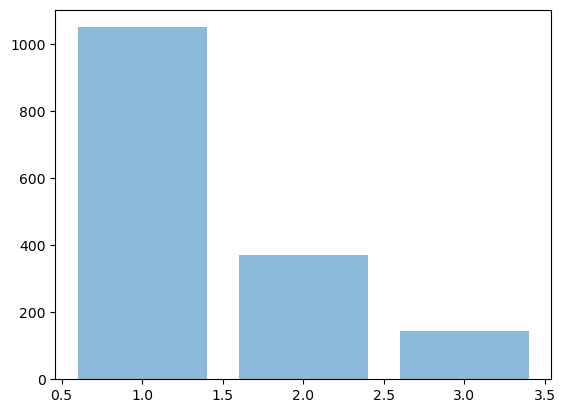

In [18]:
plt.bar([1,2,3], s, alpha=0.5,align='center', label='individual explained variance')
plt.show()

In [19]:
preds_data_with_noise_scaled = train_and_pred_dataset(data_with_noise_scaled)

100%|████████████████████████████████████████| 100/100 [00:40<00:00,  2.49it/s]


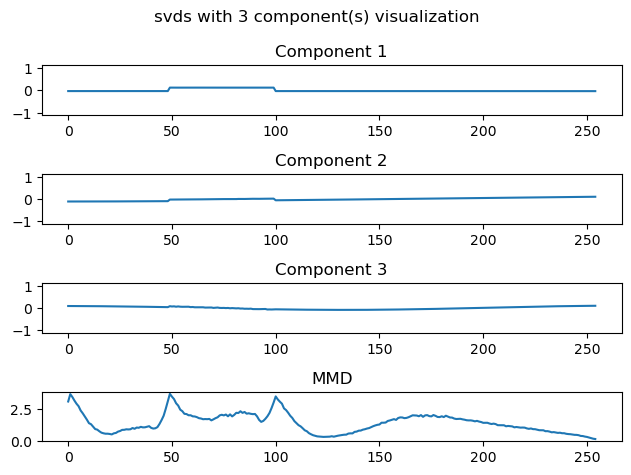

In [20]:
plot_data(data_with_noise_scaled, preds_data_with_noise_scaled, svd_method)

Train model without normalizing the noise data

In [19]:
svd_method = 'svds'
components = 3
data_with_noise_svd, s, v = svd_wrapper(data_with_noise, components, method=svd_method)
data_with_noise_svd.shape

(255, 3)

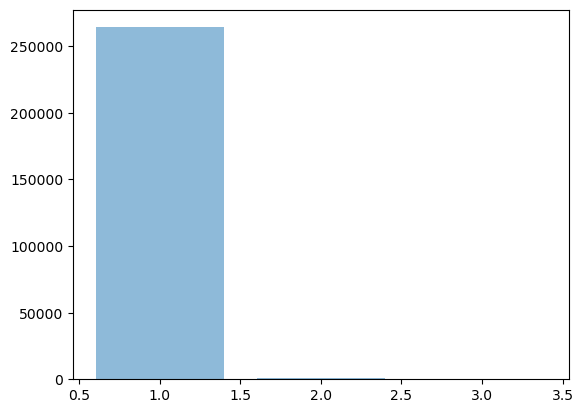

In [20]:
plt.bar([i for i in range(1,components+1)], s, alpha=0.5,align='center', label='individual explained variance')
plt.show()

In [21]:
preds_data_with_noise = train_and_pred_dataset(data_with_noise_svd)

100%|████████████████████████████████████████| 100/100 [00:42<00:00,  2.37it/s]


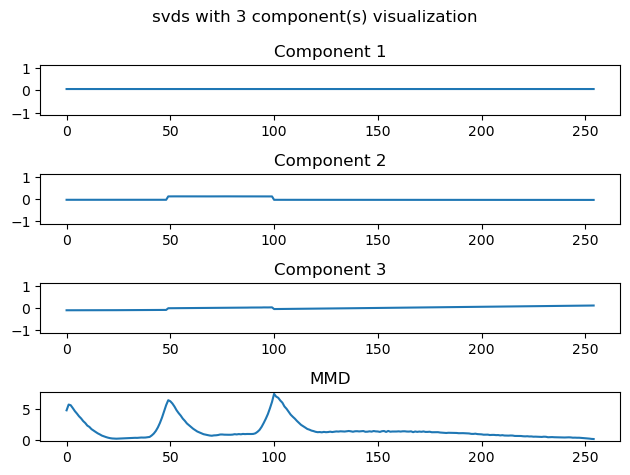

In [22]:
plot_data(data_with_noise_svd, preds_data_with_noise, svd_method)

Using only 2nd and 3rd components to train the model

In [33]:
# find index and max value of sigma s
skip_component = np.argmax(s)
skip_component, s[skip_component]

(0, 264287.5937061282)

In [23]:
preds_data_with_noise = train_and_pred_dataset(data_with_noise_svd[:,1:])

100%|████████████████████████████████████████| 100/100 [00:41<00:00,  2.40it/s]


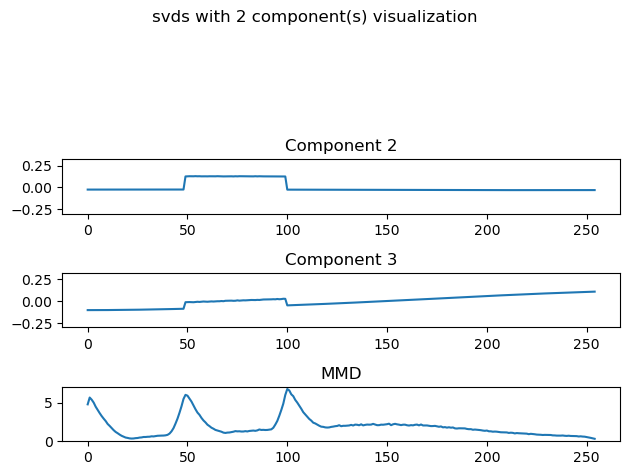

In [35]:
plot_data(data_with_noise_svd, preds_data_with_noise, svd_method, skip_components=skip_component+1)

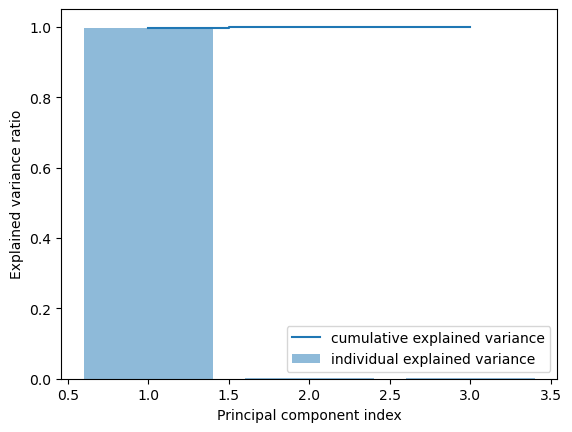

In [36]:
# calculate cumulative sum of explained variances
tot = sum(s)
var_exp = [(i / tot) for i in s]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.bar(range(1,4), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,4), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

SVDS using 2 components

In [41]:
svd_method = 'svds'
components = 4
data_with_noise_svd, s, v = svd_wrapper(data_with_noise, components, method=svd_method)
data_with_noise_svd.shape

(255, 4)

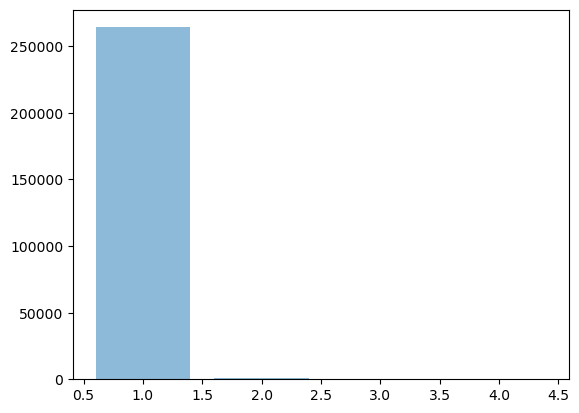

In [42]:
plt.bar([i for i in range(1,components+1)], s, alpha=0.5,align='center', label='individual explained variance')
plt.show()

array([2.64287594e+05, 7.77569079e+02, 3.71317685e+02, 1.44527247e+02])

In [48]:
# find index and max value of sigma s
skip_component = np.argmax(s)
skip_component, s[skip_component]

(0, 264287.59370612825)

In [49]:
preds_data_with_noise = train_and_pred_dataset(data_with_noise_svd[:,skip_component+1:])

100%|████████████████████████████████████████| 100/100 [00:41<00:00,  2.40it/s]


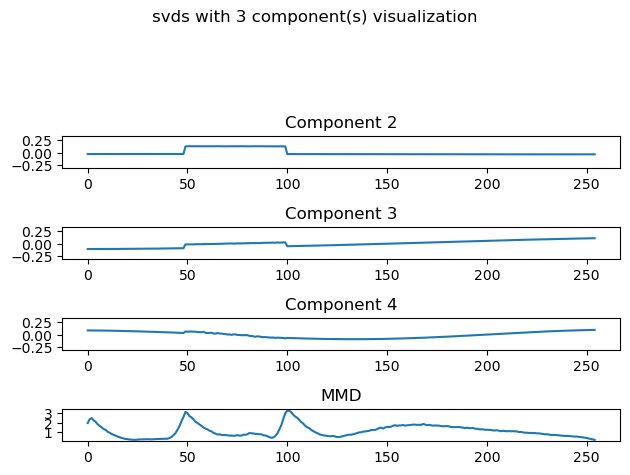

In [57]:
plot_data(data_with_noise_svd, preds_data_with_noise, svd_method, skip_components=skip_component+1)

Random SVD using 2 components

In [58]:
svd_method = 'random'
components = 2
data_with_noise_svd, s, v = svd_wrapper(data_with_noise, components, method=svd_method)
data_with_noise_svd.shape

(255, 2)

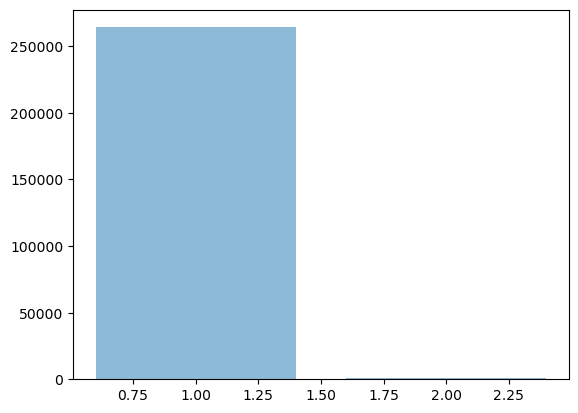

In [59]:
plt.bar([i for i in range(1,components+1)], s, alpha=0.5,align='center', label='individual explained variance')
plt.show()

In [60]:
preds_data_with_noise = train_and_pred_dataset(data_with_noise_svd)

100%|████████████████████████████████████████| 100/100 [00:42<00:00,  2.36it/s]


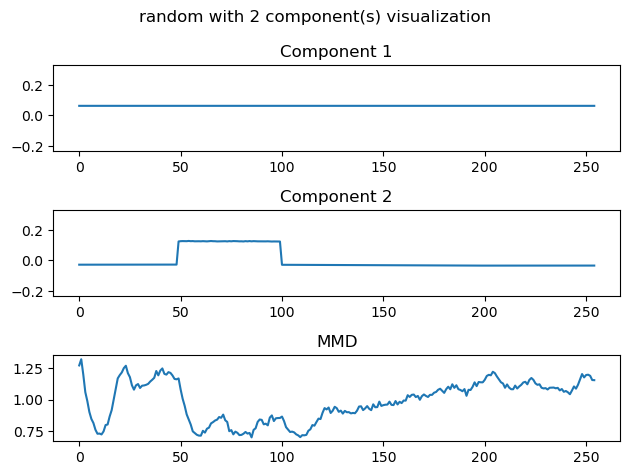

In [61]:
plot_data(data_with_noise_svd, preds_data_with_noise, svd_method)

Random SVD using 3 components

In [62]:
svd_method = 'random'
components = 3
data_with_noise_svd, s, v = svd_wrapper(data_with_noise, components, method=svd_method)
data_with_noise_svd.shape

(255, 3)

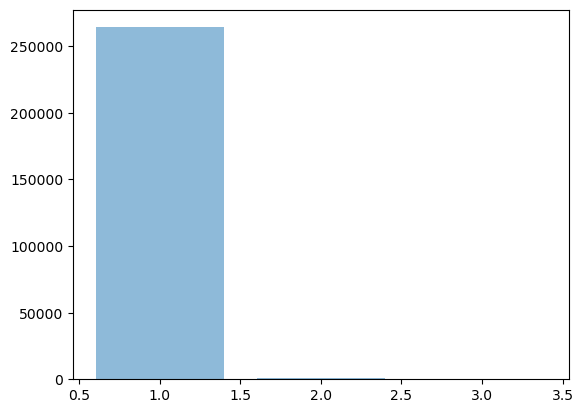

In [63]:
plt.bar([i for i in range(1,components+1)], s, alpha=0.5,align='center', label='individual explained variance')
plt.show()

In [64]:
preds_data_with_noise = train_and_pred_dataset(data_with_noise_svd)

100%|████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


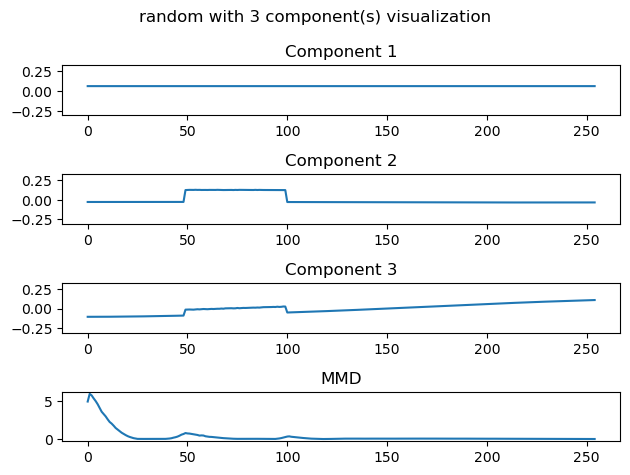

In [65]:
plot_data(data_with_noise_svd, preds_data_with_noise, svd_method)

Skipping the highest variance component

In [66]:
skip_component = np.argmax(s)
skip_component, s[skip_component]

(0, 264287.59370612825)

In [67]:
preds_data_with_noise = train_and_pred_dataset(data_with_noise_svd[:,skip_component+1:])

100%|████████████████████████████████████████| 100/100 [00:42<00:00,  2.35it/s]


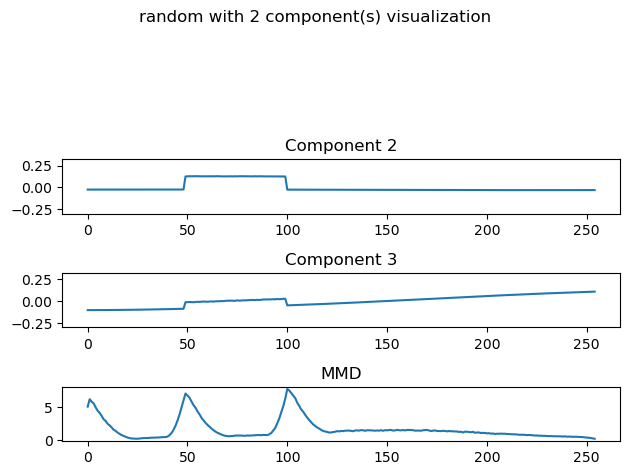

In [68]:
plot_data(data_with_noise_svd, preds_data_with_noise, svd_method, skip_components=skip_component+1)

SVD Linear algebra function using 3 components

In [69]:
svd_method = 'Linear Alg'
components = 3
data_with_noise_svd, s, v = svd_wrapper(data_with_noise, components, method=svd_method)
data_with_noise_svd.shape

(255, 3)

In [74]:
# get values from s matrix
s = np.diag(s)
s

array([264287.59370613,    777.56907939,    371.31768476])

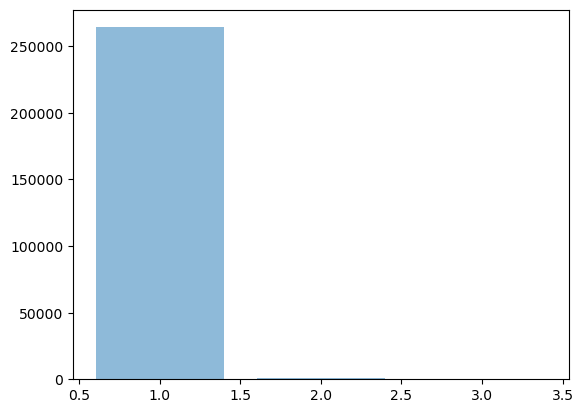

In [75]:
plt.bar([i for i in range(1,components+1)], s, alpha=0.5,align='center', label='individual explained variance')
plt.show()

In [76]:
preds_data_with_noise = train_and_pred_dataset(data_with_noise_svd)

100%|████████████████████████████████████████| 100/100 [00:40<00:00,  2.50it/s]


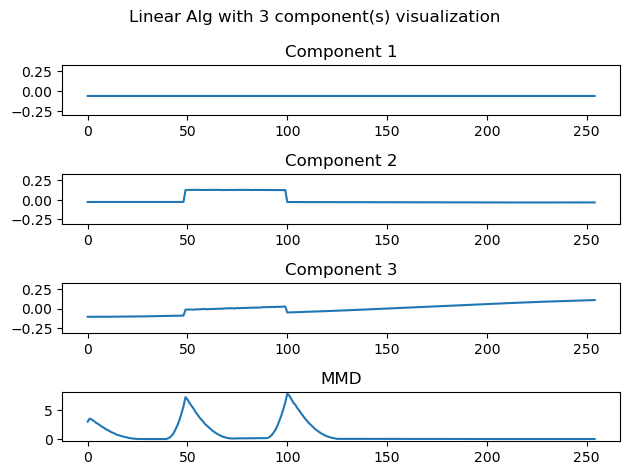

In [77]:
plot_data(data_with_noise_svd, preds_data_with_noise, svd_method)

Skip the first component

In [78]:
skip_component = np.argmax(s)
skip_component, s[skip_component]

(0, 264287.5937061283)

In [79]:
preds_data_with_noise = train_and_pred_dataset(data_with_noise_svd[:,skip_component+1:])

100%|████████████████████████████████████████| 100/100 [00:37<00:00,  2.66it/s]


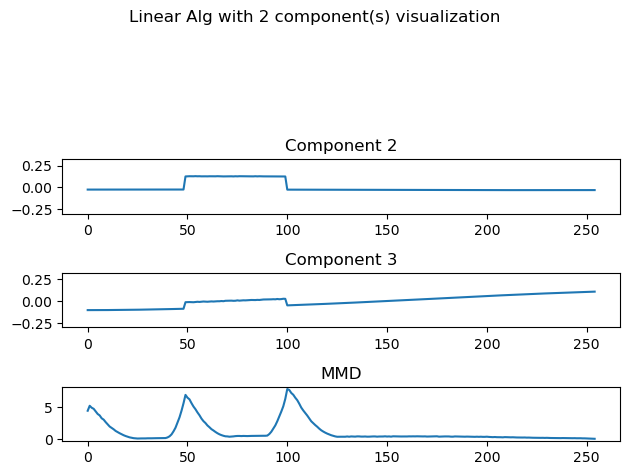

In [80]:
plot_data(data_with_noise_svd, preds_data_with_noise, svd_method, skip_components=skip_component+1)